In [1]:
!pwd
%matplotlib inline
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tf_2_work/statistical_test_sample


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# ポケモンを題材に因果推論を実践してみる
- https://tepppei.hatenablog.com/

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('pokemon_ball_data.csv')
df.info()
display(df.head())
display(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
Unnamed: 0      100 non-null int64
rarity          100 non-null int64
ball_type       100 non-null object
thrown_balls    100 non-null int64
dtypes: int64(3), object(1)
memory usage: 3.2+ KB


,Unnamed: 0,rarity,ball_type,thrown_balls
0,0,110,super,3
1,1,230,monster,2
2,2,110,super,4
3,3,110,super,1
4,4,120,super,2


,Unnamed: 0,rarity,ball_type,thrown_balls
count,100.000000,100.000,100,100.000000
unique,NaN,NaN,2,NaN
top,NaN,NaN,monster,NaN
freq,NaN,NaN,50,NaN
mean,49.500000,132.900,NaN,5.980000
std,29.011492,72.826,NaN,6.482268
min,0.000000,10.000,NaN,1.000000
25%,24.750000,65.000,NaN,1.000000
50%,49.500000,132.500,NaN,3.500000
75%,74.250000,201.250,NaN,7.250000


## 対応のないt検定

In [3]:
# https://www.haya-programming.com/entry/2019/05/24/005837
from scipy import stats
from statsmodels.stats.weightstats import ttest_ind
from statistics import mean, median,variance,stdev

m_throws = df[df['ball_type'] == 'monster']['thrown_balls']
print(f"variance(m_throws): {variance(m_throws):.2f}")

s_throws = df[df['ball_type'] == 'super']['thrown_balls']
print(f"variance(s_throws): {variance(s_throws):.2f}")

# 引数:alternative は"two-sided"と"larger"と"smaller"が渡せます。後ろの2つは片側のオプション
# 引数:usevar は"pooled"と"unequal"が渡せます。スチューデントのt検定とウェルチのt検定に対応
# 等分散でなさそうなのでウェルチのt検定つかう
t_val, p_val, free = ttest_ind(m_throws, 
                               s_throws, 
                               alternative='two-sided',
                               usevar="unequal")
print(f"ttest: t_val, p_val, free: {t_val:.2f}, {p_val:.2f}, {free:.2f}")
# p値>0.05なので、帰無仮説棄却できない=平均の差がない
# スーパーボールの方が性能いいとはならなかった
# 直観と違うのでセレクションバイアスの可能性ある

variance(m_throws): 29.97
variance(s_throws): 53.75
ttest: t_val, p_val, free: -1.17, 0.24, 90.69


## 交絡因子の存在をデータ可視化で確認

,rarity,m_thrown,s_thrown
0,10,NaN,36.0
1,15,NaN,6.0
2,20,NaN,14.0
3,25,NaN,2.0
4,30,NaN,9.0


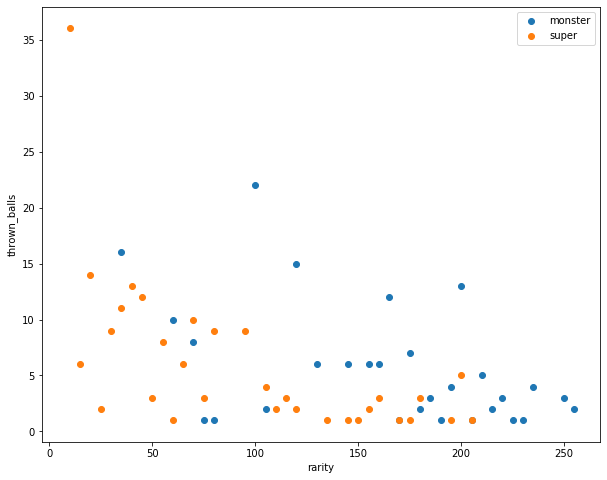

In [4]:
m_thrown = pd.Series(df[df['ball_type'] == 'monster'].groupby('rarity')['thrown_balls'].mean().astype(int), name='m_thrown')
s_thrown = pd.Series(df[df['ball_type'] == 'super'].groupby('rarity')['thrown_balls'].mean().astype(int), name='s_thrown')
df_m_s_thrown = pd.concat([m_thrown, s_thrown], axis=1).reset_index()
display(df_m_s_thrown.head())

# ボールの種類と捕まえやすさ・使ったボールの個数の関係
# rarityはレア度。小さいほどレアポケ
plt.figure(figsize=(10,8))
plt.scatter(df_m_s_thrown['rarity'], df_m_s_thrown.iloc[:,1], label='monster')
plt.scatter(df_m_s_thrown['rarity'], df_m_s_thrown.iloc[:,2], label='super')
plt.xlabel('rarity')
plt.ylabel('thrown_balls')
plt.legend()
plt.show()
# 捕まえやすいポケモンほどモンスターボールが使われやすい傾向にある

## 線形回帰によるモデル化
#### t検定と同じく、ボール投げる数を目的変数:y、ボールタイプを説明変数:x とした線形回帰モデルをスーパーボールとモンスターボールでそれぞれ作成
<br>

#### 結果：
- スーパーボールのモデル:y = 6.7400*x + b: 1回投げるとボール6個分の効果がある
- モンスターボールのモデル:y = 5.2200*x + b : 1回投げるのにボール5個分の効果がある

<br>

#### t検定と同じく、（重みの）差があまりない

In [5]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

df_dummy = pd.get_dummies(df, columns=['ball_type'])
display(df_dummy.head())
df_dummy.info()

,Unnamed: 0,rarity,thrown_balls,ball_type_monster,ball_type_super
0,0,110,3,0,1
1,1,230,2,1,0
2,2,110,4,0,1
3,3,110,1,0,1
4,4,120,2,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
Unnamed: 0           100 non-null int64
rarity               100 non-null int64
thrown_balls         100 non-null int64
ball_type_monster    100 non-null uint8
ball_type_super      100 non-null uint8
dtypes: int64(3), uint8(2)
memory usage: 2.7 KB


                 Generalized Linear Model Regression Results                  
Dep. Variable:           thrown_balls   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          55.198
Method:                          IRLS   Log-Likelihood:                -341.94
Date:                Thu, 14 May 2020   Deviance:                       5464.6
Time:                        03:14:58   Pearson chi2:                 5.46e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ball_type_super     6.7400      1.051     

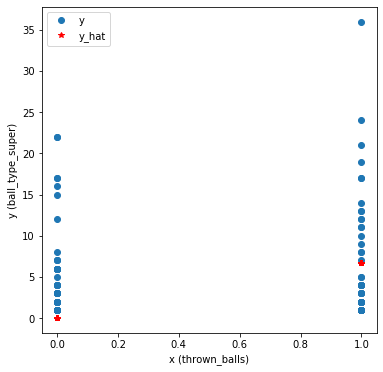

In [6]:
# 線形回帰
# 線形予測子・確率分布・リンク関数の推定
y = df_dummy['thrown_balls'] # 目的変数：y ボール投げた数
x = df_dummy['ball_type_super'] # 説明変数：x（線形予測子：wx）ボールのタイプ（スーパーボール）
link = sm.families.links.identity() # リンク関数：恒等リンク関数
family = sm.families.Gaussian(link) # 確率分布：ガウス分布

# model
model = sm.GLM(y, x, family=family)
results = model.fit()
print(results.summary())

# 重み
w = results.params[0]

# フィッティング直線
y_hat = w * x

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(x, y, "o", label='y')
plt.plot(x, y_hat, "*", color="r", label='y_hat')
plt.xlabel('x (thrown_balls)')
plt.ylabel('y (ball_type_super)')
plt.legend()
plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:           thrown_balls   No. Observations:                  100
Model:                            GLM   Df Residuals:                       99
Model Family:                Gaussian   Df Model:                            0
Link Function:               identity   Scale:                          64.380
Method:                          IRLS   Log-Likelihood:                -349.63
Date:                Thu, 14 May 2020   Deviance:                       6373.6
Time:                        03:14:58   Pearson chi2:                 6.37e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ball_type_monster     5.2200      1.13

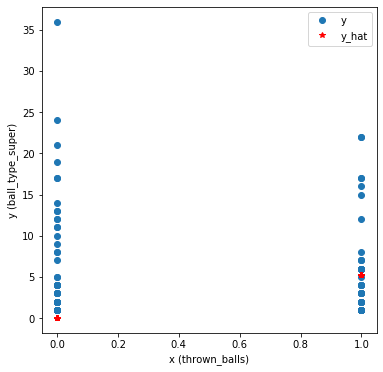

In [7]:
# 線形回帰
# 線形予測子・確率分布・リンク関数の推定
y = df_dummy['thrown_balls'] # 目的変数：y ボール投げた数
x = df_dummy['ball_type_monster'] # 説明変数：x（線形予測子：wx）ボールのタイプ（モンスターボール）
link = sm.families.links.identity() # リンク関数：恒等リンク関数
family = sm.families.Gaussian(link) # 確率分布：ガウス分布

# model
model = sm.GLM(y, x, family=family)
results = model.fit()
print(results.summary())

# 重み
w = results.params[0]

# フィッティング直線
y_hat = w * x

# 予測結果の可視化
fig = plt.figure(figsize=(6.0, 6.0))
plt.plot(x, y, "o", label='y')
plt.plot(x, y_hat, "*", color="r", label='y_hat')
plt.xlabel('x (thrown_balls)')
plt.ylabel('y (ball_type_super)')
plt.legend()
plt.show()

## 線形重回帰によるモデル化（交絡因子の説明変数を増やす）
#### ボール投げる数を目的変数:y、ボールタイプとポケモンの捕獲しやすさを説明変数:x1,x2 とした線形重回帰モデルをスーパーボールとモンスターボールでそれぞれ作成
<br>

#### 結果：
- スーパーボールのモデル:y = 5.3877 * x1 + 0.0153 * x2 + b: 1回投げるとボール5個分の効果がある
- モンスターボールのモデル:y = 2.1026 * x1 + 0.0176 * x2 + b : 1回投げるとボール2個分の効果がある

<br>

#### t検定と違い、（重み）ボール3個分の差があることが言える

In [8]:
# 線形重回帰
# 線形予測子・確率分布・リンク関数の推定
y = df_dummy['thrown_balls'] # 目的変数：y = ボール投げた数
x = df_dummy[['ball_type_super', 'rarity']] # 説明変数：x（線形予測子：wx）= ボールのタイプ（スーパーボール）+ ポケモンの捕獲しやすさ
link = sm.families.links.identity() # リンク関数：恒等リンク関数
family = sm.families.Gaussian(link) # 確率分布：ガウス分布

# model
model = sm.GLM(y, x, family=family)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           thrown_balls   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          51.198
Method:                          IRLS   Log-Likelihood:                -337.67
Date:                Thu, 14 May 2020   Deviance:                       5017.4
Time:                        03:14:58   Pearson chi2:                 5.02e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ball_type_super     5.3877      1.111     

In [9]:
# 線形重回帰
# 線形予測子・確率分布・リンク関数の推定
y = df_dummy['thrown_balls'] # 目的変数：y = ボール投げた数
x = df_dummy[['ball_type_monster', 'rarity']] # 説明変数：x（線形予測子：wx）= ボールのタイプ（モンスターボール）+ ポケモンの捕獲しやすさ
link = sm.families.links.identity() # リンク関数：恒等リンク関数
family = sm.families.Gaussian(link) # 確率分布：ガウス分布

# model
model = sm.GLM(y, x, family=family)
results = model.fit()
print(results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           thrown_balls   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                          62.791
Method:                          IRLS   Log-Likelihood:                -347.87
Date:                Thu, 14 May 2020   Deviance:                       6153.5
Time:                        03:14:58   Pearson chi2:                 6.15e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ball_type_monster     2.1026      2.00